In [1]:
# library versions.

# pandas version 1.1.3
# numpy version 1.19.2
# sklearn version 0.23.2
# matplotlib version 3.3.2

In [74]:
# import dependencies.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from joblib import dump, load
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
profile_df = pd.read_csv('fraud_profile.csv')

In [76]:
behavior_df = pd.read_csv('fraud_behavior.csv')

In [77]:
profile_df.head()

,user,fraud,email_domain,ip_asn,signup_datetime,gender,marital,employment,pet
0,1000000,0,c,11202,2020-05-03 17:29:33,1.0,Married,i,['No pets']
1,1000015,0,f,11202,2020-05-03 17:32:33,1.0,Married,d,['Cat']
2,1000019,0,c,11202,2020-05-03 17:33:52,1.0,Single,f,['No pets']
3,1000045,0,c,11202,2020-05-03 17:37:58,1.0,Married,f,['No pets']
4,1000076,0,c,11202,2020-05-03 17:42:42,0.0,Single,b,['No pets']


In [78]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70283 entries, 0 to 70282
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user             70283 non-null  int64  
 1   fraud            70283 non-null  int64  
 2   email_domain     70283 non-null  object 
 3   ip_asn           70283 non-null  int64  
 4   signup_datetime  70283 non-null  object 
 5   gender           70021 non-null  float64
 6   marital          70282 non-null  object 
 7   employment       70272 non-null  object 
 8   pet              70271 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.8+ MB


In [8]:
# we have a few missing values here, so we will delete them all.

profile_df = profile_df.dropna()

In [9]:
# remove duplicate lines as well.

profile_df = profile_df.drop_duplicates()

In [10]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69995 entries, 0 to 70282
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user             69995 non-null  int64  
 1   fraud            69995 non-null  int64  
 2   email_domain     69995 non-null  object 
 3   ip_asn           69995 non-null  int64  
 4   signup_datetime  69995 non-null  object 
 5   gender           69995 non-null  float64
 6   marital          69995 non-null  object 
 7   employment       69995 non-null  object 
 8   pet              69995 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 5.3+ MB


In [79]:
behavior_df.head()

,user,click_time,length_of_activity_in_minutes,promised_reward,ip_asn,postback_time,activity_status,gained_reward
0,1000000,2020-05-03 17:33:15,25.0,12300.0,11202,2020-05-03 17:33:50,rejection_type_2,369.0
1,1000000,2020-05-03 17:33:50,25.0,12300.0,11202,NaN,NaN,NaN
2,1000002,2020-05-03 17:34:02,25.0,12300.0,11678,2020-05-03 17:34:40,rejection_type_2,369.0
3,1000007,2020-05-03 17:34:12,25.0,6150.0,10066,NaN,NaN,NaN
4,1000002,2020-05-03 17:34:40,25.0,12300.0,11678,NaN,NaN,NaN


In [12]:
# here, we will remove the missing values for important columns in order to lose less information,  
# instead of deleting it in all of the columns.

behavior_df = behavior_df.dropna(subset = ['user', 'click_time', 'length_of_activity_in_minutes', 
                                           'promised_reward', 'gained_reward'])

In [13]:
behavior_df = behavior_df.drop_duplicates()

In [14]:
behavior_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1801354 entries, 0 to 4326279
Data columns (total 8 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   user                           int64  
 1   click_time                     object 
 2   length_of_activity_in_minutes  float64
 3   promised_reward                float64
 4   ip_asn                         int64  
 5   postback_time                  object 
 6   activity_status                object 
 7   gained_reward                  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 123.7+ MB


In [15]:
# transfer the columns containing the date to the correct form.

behavior_df['postback_time'] = pd.to_datetime(behavior_df["postback_time"])

behavior_df['click_time'] = pd.to_datetime(behavior_df["click_time"])

In [16]:
# create a new column for the duration of user activity in seconds.

behavior_df['activity_duration'] = behavior_df['postback_time'] - behavior_df['click_time']

behavior_df['activity_duration'] = behavior_df['activity_duration'].dt.total_seconds()

In [17]:
# remove the original columns because they will correlate very strongly with the new one.

behavior_df.drop(['click_time', "postback_time"], axis=1, inplace=True)

In [18]:
# we will also delete the ip addresses because they have no numerical meaning and there are too 
# many of them as categories.

behavior_df.drop('ip_asn', axis=1, inplace=True)

profile_df.drop('ip_asn', axis=1, inplace=True)

In [19]:
# we will encode all our categorical features into a number, but set their type to categorical 
# so that our model does not compare them by greater or smaller.

activity_status_mapping = {'rejection_type_1': 1, 'rejection_type_2': 2, 'rejection_type_3': 3, 
                           'rejection_type_4': 4, 'rejection_type_5': 5, 'successfull': 6}

behavior_df['activity_status'] = behavior_df['activity_status'].map(activity_status_mapping)

behavior_df['activity_status'] = behavior_df['activity_status'].astype('category')



email_domain_mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7}

profile_df['email_domain'] = profile_df['email_domain'].map(email_domain_mapping)

profile_df['email_domain'] = profile_df['email_domain'].astype('category')



marital_mapping = {'Single': 0, 'Married': 1, 'Divorced': 2}

profile_df['marital'] = profile_df['marital'].map(marital_mapping)

profile_df['marital'] = profile_df['marital'].astype('category')



employment_mapping = {'i': 1, 'd': 2, 'f': 3, 'b': 4, 'c': 5, 'k': 6, 'g': 7, 'h': 8, 'e': 9, 'a': 10, 'j': 11}

profile_df['employment'] = profile_df['employment'].map(employment_mapping)

profile_df['employment'] = profile_df['employment'].astype('category')


profile_df['gender'] = profile_df['gender'].astype('int')

profile_df['gender'] = profile_df['gender'].astype('category')



profile_df['fraud'] = profile_df['fraud'].astype('category')

In [20]:
# remove unnecessary characters from 'pet' and also convert to categories.

profile_df['pet'] = profile_df['pet'].str.strip("[], '")

profile_df['pet'] = profile_df['pet'].apply(lambda pet: 0 if pet == 'No pets' else 1)

profile_df['pet'] = profile_df['pet'].astype('category')

In [21]:
profile_df.head()

,user,fraud,email_domain,signup_datetime,gender,marital,employment,pet
0,1000000,0,3,2020-05-03 17:29:33,1,1,1,0
1,1000015,0,6,2020-05-03 17:32:33,1,1,2,1
2,1000019,0,3,2020-05-03 17:33:52,1,0,3,0
3,1000045,0,3,2020-05-03 17:37:58,1,1,3,0
4,1000076,0,3,2020-05-03 17:42:42,0,0,4,0


In [22]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69995 entries, 0 to 70282
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   user             69995 non-null  int64   
 1   fraud            69995 non-null  category
 2   email_domain     69995 non-null  category
 3   signup_datetime  69995 non-null  object  
 4   gender           69995 non-null  category
 5   marital          69995 non-null  category
 6   employment       69995 non-null  category
 7   pet              69995 non-null  category
dtypes: category(6), int64(1), object(1)
memory usage: 2.0+ MB


In [23]:
# now we will group our dataframe by the user column and aggregate it with the average of our quantitative data.

behavior_df = behavior_df.groupby('user')['length_of_activity_in_minutes', 'promised_reward',   
                                          'gained_reward', 'activity_duration'].agg('mean')

In [24]:
# now we can merge our dataframes by unique user.

df = profile_df.merge(behavior_df, on='user', how='inner')

In [25]:
# we can now delete the 'user' and 'signup_datetime' columns since they are unique 
# and have no numerical meaning.

df.drop(['user', 'signup_datetime'], axis=1, inplace=True)

In [26]:
df.head()

,fraud,email_domain,gender,marital,employment,pet,length_of_activity_in_minutes,promised_reward,gained_reward,activity_duration
0,0,3,1,1,1,0,25.000000,12300.00,369.0,35.00
1,0,6,1,1,2,1,13.500000,10301.25,3505.5,577.75
2,0,3,1,0,3,0,25.000000,12300.00,0.0,12.00
3,0,3,1,1,3,0,25.000000,12300.00,369.0,56.00
4,0,3,0,0,4,0,12.333333,9430.00,328.0,276.00


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49102 entries, 0 to 49101
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   fraud                          49102 non-null  category
 1   email_domain                   49102 non-null  category
 2   gender                         49102 non-null  category
 3   marital                        49102 non-null  category
 4   employment                     49102 non-null  category
 5   pet                            49102 non-null  category
 6   length_of_activity_in_minutes  49102 non-null  float64 
 7   promised_reward                49102 non-null  float64 
 8   gained_reward                  49102 non-null  float64 
 9   activity_duration              49102 non-null  float64 
dtypes: category(6), float64(4)
memory usage: 2.2 MB


In [28]:
# now we will separate our features and target variables.

X = df.drop('fraud', axis=1)

y = df[['fraud']]

In [29]:
# let's look at our feature distribution.

# here you can see that we have a large standard deviation from the mean for our continuous variables.

X.describe()

,length_of_activity_in_minutes,promised_reward,gained_reward,activity_duration
count,49102.000000,49102.000000,49102.000000,49102.000000
mean,14.691641,9407.008667,1039.013223,330.305058
std,7.670005,5716.838070,1501.908947,3515.478690
min,0.000000,0.000000,0.000000,0.000000
25%,11.600000,6501.428571,246.000000,73.000000
50%,14.250000,8302.500000,421.714286,164.109441
75%,17.000000,10703.850684,1373.500000,314.638929
max,420.000000,184500.000000,55350.000000,683915.000000


In [30]:
# normalize our training data close to a Gaussian distribution with 0 mean and unit variance.

scaler = StandardScaler()

scaled_features = X.copy()

col_names = ['length_of_activity_in_minutes', 'promised_reward', 'gained_reward', 'activity_duration']
features = scaled_features[col_names]
scaler = scaler.fit(features.values)
features = scaler.transform(features.values)

X[col_names] = features

In [31]:
X.head()

,email_domain,gender,marital,employment,pet,length_of_activity_in_minutes,promised_reward,gained_reward,activity_duration
0,3,1,1,1,0,1.343997,0.506053,-0.446112,-0.084002
1,6,1,1,2,1,-0.155365,0.156424,1.642251,0.070388
2,3,1,0,3,0,1.343997,0.506053,-0.691802,-0.090545
3,3,1,1,3,0,1.343997,0.506053,-0.446112,-0.078029
4,3,0,0,4,0,-0.307475,0.004022,-0.473411,-0.015448


In [32]:
X.describe()

,length_of_activity_in_minutes,promised_reward,gained_reward,activity_duration
count,4.910200e+04,4.910200e+04,4.910200e+04,4.910200e+04
mean,1.996783e-16,2.825906e-16,3.578526e-16,-4.226476e-17
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-1.915486e+00,-1.645508e+00,-6.918021e-01,-9.395831e-02
25%,-4.030861e-01,-5.082547e-01,-5.280089e-01,-7.319279e-02
50%,-5.758088e-02,-1.932047e-01,-4.110137e-01,-4.727587e-02
75%,3.009623e-01,2.268483e-01,2.227100e-01,-4.456374e-03
max,5.284383e+01,3.062791e+01,3.616167e+01,1.944519e+02


In [33]:
# correlation matrix.
corr_metrics = X.corr()
corr_metrics.style.background_gradient()

,length_of_activity_in_minutes,promised_reward,gained_reward,activity_duration
length_of_activity_in_minutes,1.000000,0.676620,-0.045948,-0.026824
promised_reward,0.676620,1.000000,-0.021468,-0.027760
gained_reward,-0.045948,-0.021468,1.000000,0.040993
activity_duration,-0.026824,-0.027760,0.040993,1.000000


In [34]:
X.shape

(49102, 9)

In [35]:
random_state = 42

In [36]:
# we will divide the training and test datasets 1/5 with strotification by y so that both classes are present 
# in the training and testing datasets according to the same ratio.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [37]:
print(X_train.shape, y_train.shape)

(39281, 9) (39281, 1)


In [38]:
print(X_test.shape, y_test.shape)

(9821, 9) (9821, 1)


In [39]:
# check the ratio of classes.

print('Train', y_train.value_counts(), '\n')

print('Test', y_test.value_counts())

Train fraud
0        36554
1         2727
dtype: int64 

Test fraud
0        9139
1         682
dtype: int64


In [40]:
# balance our training data with UnderSampling. 

rus = RandomUnderSampler(random_state=random_state)

X_train, y_train = rus.fit_resample(X_train, y_train)

In [41]:
# check the ratio of classes.

print('Train', y_train.value_counts(), '\n')

print('Test', y_test.value_counts())

Train fraud
1        2727
0        2727
dtype: int64 

Test fraud
0        9139
1         682
dtype: int64


In [42]:
# apply encoding for more understandable kinds of categorical features for our model.

X_train = pd.get_dummies(X_train, columns=['email_domain', 'gender', 'marital', 'employment', 'pet'],
                         drop_first=True, prefix='C')


X_test = pd.get_dummies(X_test, columns=['email_domain', 'gender', 'marital', 'employment', 'pet'],
                        drop_first=True, prefix='C')

In [43]:
X_train.head()

,length_of_activity_in_minutes,promised_reward,gained_reward,activity_duration,C_2,C_3,C_4,C_5,C_6,C_7,...,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,C_11,C_1
0,0.692100,0.936365,-0.691802,-0.085709,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0.040204,-0.569728,-0.568957,-0.048018,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1.995894,4.809174,-0.691802,-0.076606,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.692100,-0.031838,-0.568957,-0.057121,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.309166,-0.135873,0.668564,1.056535,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [44]:
# initializing the algorithm LogisticRegression Classifier.

lr = LogisticRegression(random_state=random_state)

In [45]:
# set the search space for hyperparameters.

lr_param_grid = {'penalty' : ['l1', 'l2'],
                 'C' : np.logspace(-4, 4, 20),
                 'solver' : ['liblinear']}

In [46]:
# initialize the grid model by setting the search space and 5 fold cross validation.

CV_lr = GridSearchCV(estimator=lr, param_grid=lr_param_grid, cv= 5, n_jobs=-1)

In [47]:
# apply our grid model on the training data.

CV_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [48]:
# best average accuracy score on the training data.

CV_lr.best_score_

0.8351664578410514

In [49]:
best_lr_model = CV_lr.best_estimator_

In [50]:
# prediction of our test data

lr_predictions = CV_lr.best_estimator_.predict(X_test)

lr_probs = CV_lr.best_estimator_.predict_proba(X_test)

In [51]:
# check more important metrics

print(roc_auc_score(y_test, lr_probs[:,1]))
print(classification_report(y_test, lr_predictions))
print(confusion_matrix(y_test, lr_predictions))

0.8878230932560304
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      9139
           1       0.29      0.84      0.43       682

    accuracy                           0.84      9821
   macro avg       0.64      0.84      0.67      9821
weighted avg       0.94      0.84      0.88      9821

[[7723 1416]
 [ 108  574]]


In [52]:
# let's try another algorithm.

In [53]:
# initializing the algorithm Random Forest Classifier.

rfc = RandomForestClassifier(random_state=random_state)

In [54]:
# set the search space for hyperparameters.

param_grid = {'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [100, 200, 300]}

In [55]:
# initialize the model by setting the search space and 5 fold cross validation.

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, n_jobs=-1)

In [56]:
# apply our model on the training data. 

CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300]})

In [57]:
# best chosen hyperparameters.

best_rfc_model = CV_rfc.best_estimator_

In [58]:
# best average accuracy score on the training data.

CV_rfc.best_score_

0.8758694573617337

In [59]:
# prediction of our test data.

rfc_predictions = CV_rfc.best_estimator_.predict(X_test)

rfc_probs = CV_rfc.best_estimator_.predict_proba(X_test)

In [60]:
# check more important metrics.

print(roc_auc_score(y_test, rfc_probs[:,1]))

print(classification_report(y_test, rfc_predictions))

print(confusion_matrix(y_test, rfc_predictions))

0.9278573603700938
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      9139
           1       0.38      0.85      0.52       682

    accuracy                           0.89      9821
   macro avg       0.68      0.87      0.73      9821
weighted avg       0.95      0.89      0.91      9821

[[8184  955]
 [ 100  582]]


In [61]:
# let's try to improve our model with Principal component analysis.

Text(0.5, 0, 'Principal Component #')

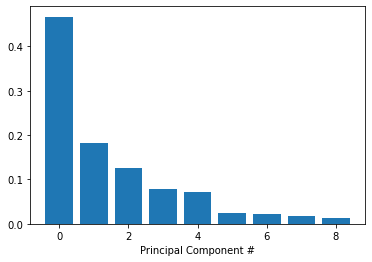

In [62]:
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(X)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

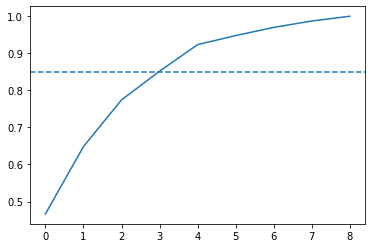

In [63]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

In [64]:
# choose the n_components where about 85% of our variance can be explained.
n_components = 5

# Perform PCA with the chosen number of components and project data onto components.

pca = PCA(n_components, random_state=random_state)
pca.fit(X)
new_X = pca.transform(X)

In [65]:
# divide the training and test datasets 1/5 with strotification by y so that both classes are present 
# in the training and test datasets according to the same ratio.

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.2, random_state=random_state, stratify=y)

In [66]:
# balance our training data with UnderSampling. 

new_X_train, new_y_train = rus.fit_resample(new_X_train, new_y_train)

In [67]:
# apply our grid model on training data. 

CV_rfc.fit(new_X_train, new_y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300]})

In [68]:
# best average accuracy score on training data.

CV_rfc.best_score_

0.8659691050210647

In [69]:
# prediction of our test data.

new_rfc_predictions = CV_rfc.best_estimator_.predict(new_X_test)

new_rfc_probs = CV_rfc.best_estimator_.predict_proba(new_X_test)

In [70]:
# check more important metrics.

print(roc_auc_score(new_y_test, new_rfc_probs[:,1]))

print(classification_report(new_y_test, new_rfc_predictions))

print(confusion_matrix(new_y_test, new_rfc_predictions))

0.9229917285944451
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      9139
           1       0.36      0.84      0.51       682

    accuracy                           0.89      9821
   macro avg       0.68      0.86      0.72      9821
weighted avg       0.94      0.89      0.91      9821

[[8145  994]
 [ 111  571]]


In [71]:
# here we can see that the PCA did not help us in this case.

In [72]:
# confusion matrix recall results.

print("using our best model, we managed to catch \n{} from {} 0 class" 
      .format(confusion_matrix(y_test, rfc_predictions)[0][0], sum(confusion_matrix(y_test, rfc_predictions)[0])),
      "and \n{} from {} 1 class".format(confusion_matrix(y_test, rfc_predictions)[1][1], 
                                        sum(confusion_matrix(y_test, rfc_predictions)[1])))

using our best model, we managed to catch 
8184 from 9139 0 class and 
582 from 682 1 class


In [73]:
# save our best model.

joblib_file = "fraud_detection_model.pkl"  
dump(best_rfc_model, joblib_file)

['fraud_detection_model.pkl']